In [472]:
# -*- encoding: utf-8 -*-

"""
@Author: Gavin
@File: titanic_prediction.py
@Software: Pycharm
@Time: 2021/2/19
@Desc:
    1.kaggle入门比赛
    2.泰坦尼克号存活乘客预测
"""

'\n@Author: Gavin\n@File: titanic_prediction.py\n@Software: Pycharm\n@Time: 2021/2/19\n@Desc:\n    1.kaggle入门比赛\n    2.泰坦尼克号存活乘客预测\n'

In [473]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import set_option
from pathlib import Path


project_path = Path.cwd().parent
project_path

seed = 42

In [474]:
# 数据集
if not os.path.exists(str(Path(project_path, "datasets/train.csv"))) or \
    not os.path.exists(str(Path(project_path, "datasets/test.csv"))):

    raise FileNotFoundError(
        "数据集不存在，请检查：{}".format(
            str(Path(project_path, "datasets/titanic.zip"))))

In [475]:
# 加载数据集并简要查看数据集
train_file = pd.read_csv(str(Path(project_path, "datasets/train.csv")))
test_file = pd.read_csv(str(Path(project_path, "datasets/test.csv")))
set_option("display.width", 200)
set_option("display.max_columns", 20)
train_file.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [476]:
test_file.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [477]:
# 查看数据结构
print("train csv info: \n", train_file.info())
print("test csv info: \n", test_file.info())
print("train csv describe\n", train_file.describe())
print("test csv  describe\n", test_file.describe())

# 可看出训练集中age、cabin、embarked有空值，测试集中age、fare、cabin有空值
# 标签中正负样本比例11:7，可能有不均衡的情况出现
# Sex、Ticket、carbin、Embarked需要转化成数值特征
# 需要对数值特征做标准化或归一化处理

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
train csv info: 
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare      

In [478]:
# 创建验证集
# (因为数据集标签1和标签0的比例为11：7，所以在进行抽样的时候采用分层抽样，保持数据分布的一致性)
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
for train_index, val_index in split.split(train_file, train_file["Survived"]):
    train_set =  train_file.loc[train_index]
    dev_set =  train_file.loc[val_index]

train_set.info()
# 可看出Age、cabin、embarked有空值
# 由于age空值不多，但是占用一定的比例，因此用平均年龄去替换空值
# cabin空值太多，而且属于类别，因此删除cabin属性
# embarked空值用中位数去填充
# 可看出name、sex、ticket、carbin、embarked是文本对象，因此将他们转化为数值对象
# 其中name、cabin属性删除

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 692 to 507
Data columns (total 12 columns):
PassengerId    712 non-null int64
Survived       712 non-null int64
Pclass         712 non-null int64
Name           712 non-null object
Sex            712 non-null object
Age            575 non-null float64
SibSp          712 non-null int64
Parch          712 non-null int64
Ticket         712 non-null object
Fare           712 non-null float64
Cabin          160 non-null object
Embarked       710 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [479]:
dev_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 565 to 637
Data columns (total 12 columns):
PassengerId    179 non-null int64
Survived       179 non-null int64
Pclass         179 non-null int64
Name           179 non-null object
Sex            179 non-null object
Age            139 non-null float64
SibSp          179 non-null int64
Parch          179 non-null int64
Ticket         179 non-null object
Fare           179 non-null float64
Cabin          44 non-null object
Embarked       179 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 18.2+ KB


In [480]:
train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
692,693,1,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0000,NaN,S
527,528,0,1,"Farthing, Mr. John",male,NaN,0,0,PC 17483,221.7792,C95,S
855,856,1,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S
801,802,1,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31.0,1,1,C.A. 31921,26.2500,NaN,S


In [481]:
# 由于创建验证集后dataframe索引依然为原来的索引，因此重置一下索引
train_set = train_set.reset_index().drop(["index"], axis=1)
train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,693,1,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S
1,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0000,NaN,S
2,528,0,1,"Farthing, Mr. John",male,NaN,0,0,PC 17483,221.7792,C95,S
3,856,1,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S
4,802,1,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31.0,1,1,C.A. 31921,26.2500,NaN,S


In [482]:
dev_set = dev_set.reset_index().drop(["index"], axis=1)
dev_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,566,0,3,"Davies, Mr. Alfred J",male,24.0,2,0,A/4 48871,24.1500,NaN,S
1,161,0,3,"Cribb, Mr. John Hatfield",male,44.0,0,1,371362,16.1000,NaN,S
2,554,1,3,"Leeni, Mr. Fahim (""Philip Zenni"")",male,22.0,0,0,2620,7.2250,NaN,C
3,861,0,3,"Hansen, Mr. Claus Peter",male,41.0,2,0,350026,14.1083,NaN,S
4,242,1,3,"Murphy, Miss. Katherine ""Kate""",female,NaN,1,0,367230,15.5000,NaN,Q


In [483]:
# 简要将数据中文本数据转化成数值特征，再观察
from sklearn.preprocessing import LabelEncoder

## 先处理缺失值
# cabin,文本属性，标签化处理
tmp_cabin = train_set["Cabin"].fillna("_")
tmp_encoder = LabelEncoder()
tmp_carbin_num = pd.Series(tmp_encoder.fit_transform(tmp_cabin))
tmp_carbin_num[tmp_carbin_num==127] = -1

# embarked
tmp_embarked = train_set["Embarked"].fillna("_")
tmp_embarked_num = pd.Series(tmp_encoder.fit_transform(tmp_embarked))

# sex
tmp_sex = pd.Series(tmp_encoder.fit_transform(train_set["Sex"]))

tmp_cat_attribs = ["Cabin", "Embarked", "Sex"]
tmp_num_attribs = [i for i in train_set.columns if i not in tmp_cat_attribs]
tmp_num_set = train_set[tmp_num_attribs]
tmp_train_set = pd.concat([tmp_num_set, tmp_carbin_num, tmp_embarked_num, 
                           tmp_sex], axis=1, ignore_index=True)
tmp_train_set.columns = tmp_num_attribs+tmp_cat_attribs
tmp_train_set

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex
0,693,1,3,"Lam, Mr. Ali",NaN,0,0,1601,56.4958,-1,2,1
1,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",NaN,0,0,239854,0.0000,-1,2,1
2,528,0,1,"Farthing, Mr. John",NaN,0,0,PC 17483,221.7792,76,2,1
3,856,1,3,"Aks, Mrs. Sam (Leah Rosen)",18.0,0,1,392091,9.3500,-1,2,0
4,802,1,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",31.0,1,1,C.A. 31921,26.2500,-1,2,0
5,653,0,3,"Kalvik, Mr. Johannes Halvorsen",21.0,0,0,8475,8.4333,-1,2,1
6,510,1,3,"Lang, Mr. Fang",26.0,0,0,1601,56.4958,-1,2,1
7,558,0,1,"Robbins, Mr. Victor",NaN,0,0,PC 17757,227.5250,-1,0,1
8,829,1,3,"McCormack, Mr. Thomas Joseph",NaN,0,0,367228,7.7500,-1,1,1
9,19,0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",31.0,1,0,345763,18.0000,-1,2,0


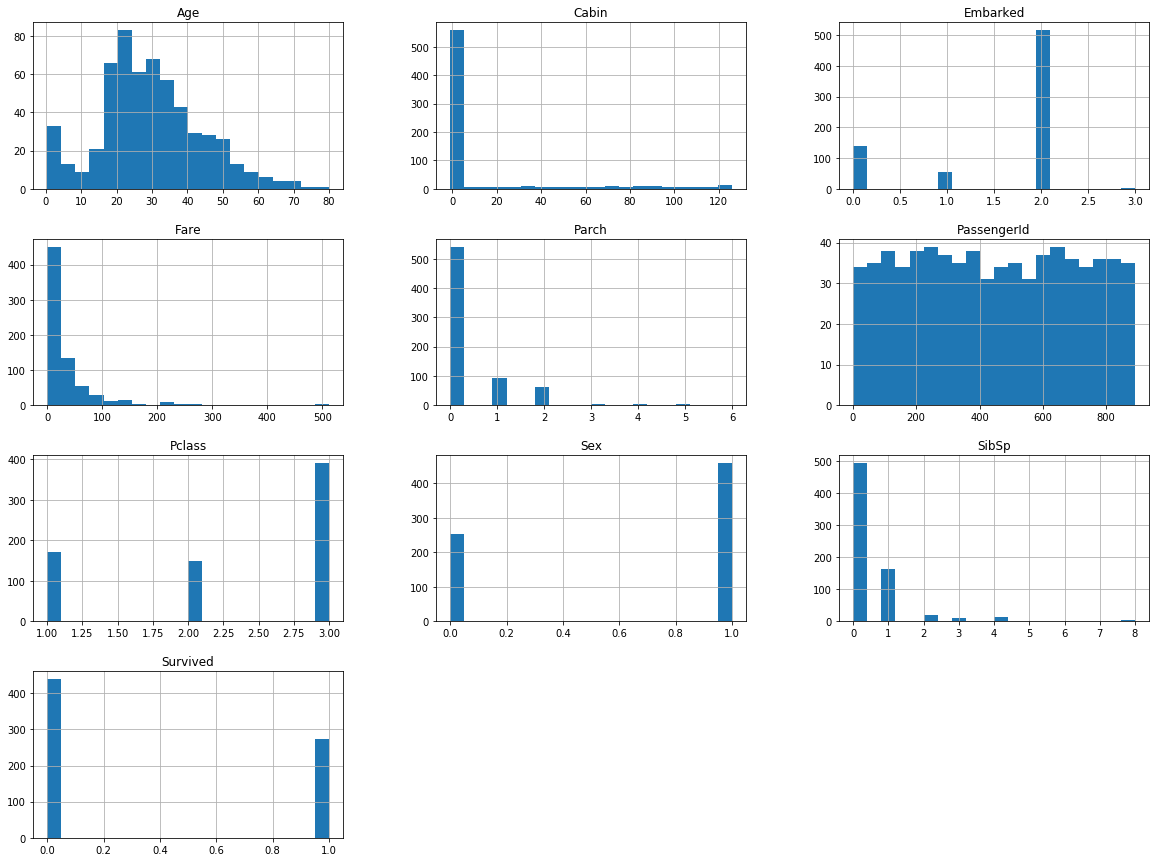

In [484]:
# 画图展示
tmp_train_set.hist(bins=20, figsize=(20, 15))
plt.tick_params(axis='x',colors='w')

plt.show()

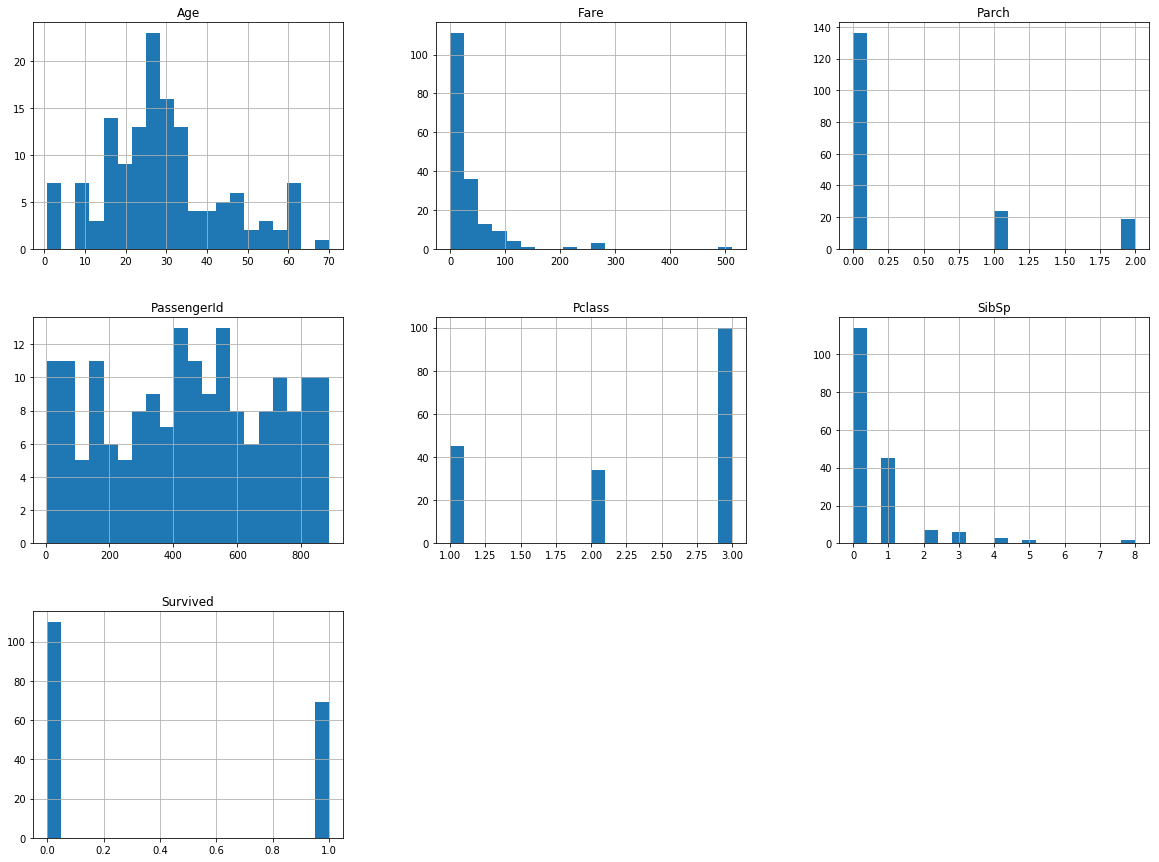

In [485]:
dev_set.hist(bins=20, figsize=(20, 15))
plt.show()

In [486]:
# 制作各种图可视化，看看数据特征的关系等
# 皮尔逊相关系数
# 由相关性矩阵可看出，票的种类和是否活着有比较大的关系，票的种类和票价有很强的正相关性
# 性别与存活率也有较大的关系，
corr_matrix = tmp_train_set.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Cabin          0.317365
Fare           0.275499
Parch          0.084178
PassengerId    0.011892
SibSp         -0.026115
Age           -0.084268
Embarked      -0.183764
Pclass        -0.348007
Sex           -0.549171
Name: Survived, dtype: float64

In [487]:
corr_matrix

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,Embarked,Sex
PassengerId,1.000000,0.011892,-0.031452,0.036080,-0.042990,-0.008022,0.013281,-0.002340,0.018554,0.020606
Survived,0.011892,1.000000,-0.348007,-0.084268,-0.026115,0.084178,0.275499,0.317365,-0.183764,-0.549171
Pclass,-0.031452,-0.348007,1.000000,-0.351089,0.097900,0.040467,-0.556540,-0.531138,0.191653,0.145052
Age,0.036080,-0.084268,-0.351089,1.000000,-0.312885,-0.175573,0.106915,0.125914,-0.032096,0.086410
SibSp,-0.042990,-0.026115,0.097900,-0.312885,1.000000,0.392269,0.127011,-0.026541,0.059692,-0.100430
Parch,-0.008022,0.084178,0.040467,-0.175573,0.392269,1.000000,0.177235,0.025866,0.044352,-0.256527
Fare,0.013281,0.275499,-0.556540,0.106915,0.127011,0.177235,1.000000,0.304306,-0.257834,-0.206986
Cabin,-0.002340,0.317365,-0.531138,0.125914,-0.026541,0.025866,0.304306,1.000000,-0.079840,-0.164877
Embarked,0.018554,-0.183764,0.191653,-0.032096,0.059692,0.044352,-0.257834,-0.079840,1.000000,0.121994
Sex,0.020606,-0.549171,0.145052,0.086410,-0.100430,-0.256527,-0.206986,-0.164877,0.121994,1.000000


/home/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4e0be9e198>,
      dtype=object)

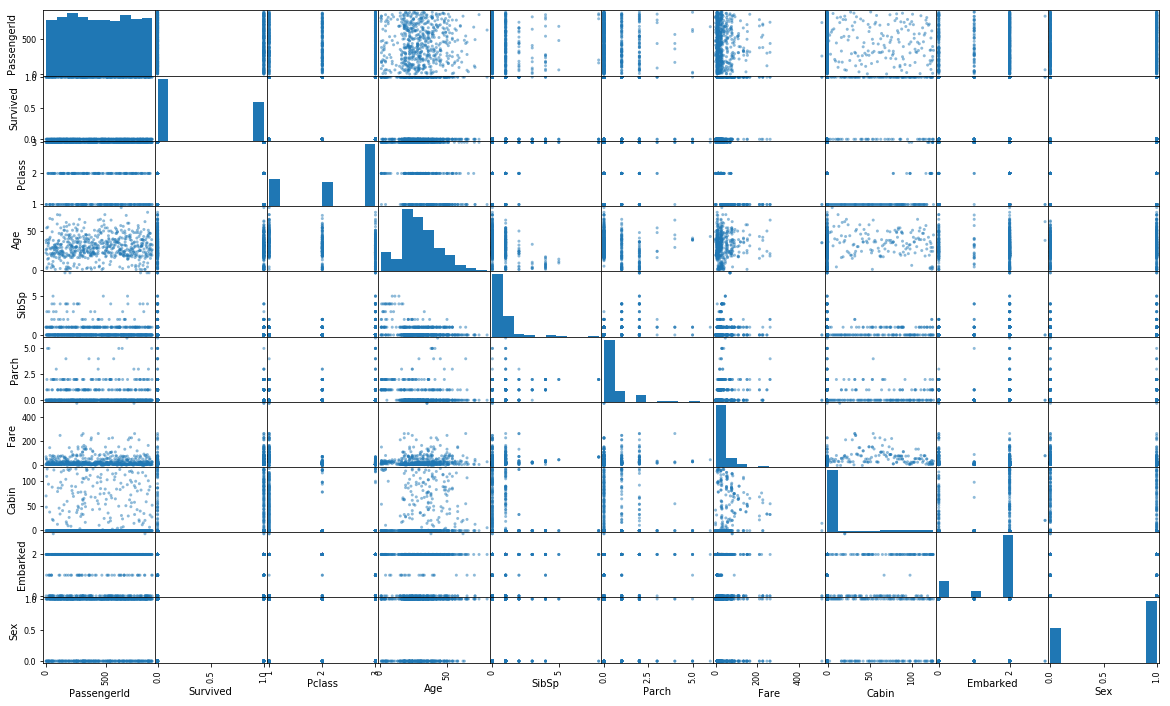

In [488]:
# 查看每个数值属性和对于其他数值属性的相关性

from pandas.tools.plotting  import scatter_matrix

attributest = tmp_train_set.columns
scatter_matrix(tmp_train_set, figsize=(20, 12))


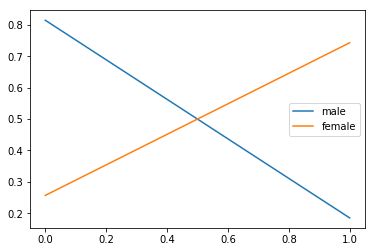

In [489]:
# 性别跟存活情况的关系
# 由此可见男性死亡率偏高，女性死亡率偏低
male = tmp_train_set[tmp_train_set["Sex"]==1]["Survived"].value_counts() 
female = tmp_train_set[tmp_train_set["Sex"]==0]["Survived"].value_counts()
sex_counts = pd.concat([male, female], axis=1)
sex_counts = sex_counts/np.sum(sex_counts, axis=0)
sex_counts.columns = ["male", "female"]
sex_counts["male"].T.plot(legend="male")
sex_counts["female"].T.plot(legend="female")

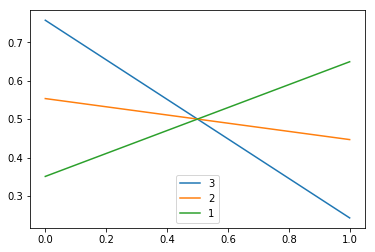

In [490]:
# pclass即票类和存活率的关系
# 说明pclass可能与存活率也有关系，是个重要的特征
third_class = tmp_train_set[tmp_train_set["Pclass"]==3]["Survived"].value_counts()
second_class = tmp_train_set[tmp_train_set["Pclass"]==2]["Survived"].value_counts()
first_class = tmp_train_set[tmp_train_set["Pclass"]==1]["Survived"].value_counts()
pclass_counts = pd.concat([third_class, second_class, first_class], axis=1)
pclass_counts = pclass_counts/np.sum(pclass_counts, axis=0)
pclass_counts.columns = ["3", "2", "1"]
pclass_counts.plot(kind="line")

In [491]:
# 由以上分析可知，存活与否与性别、座位席别、费用等特征有比较重要的关系
# 而座位席别和费用两个特征关联性很高

In [492]:
# 试验不同特征的组合
# SibSp和Parch和存活与否没有太大的关系，因此可以形成一列这两个特征的和将它们合成一个特征
# 删除名字

# 特征选择的类
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, x):
        return x[self.attribute_names]
    
# 合并属性的类
par, sib = 4, 5
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_par_and_sib=True):
        self.add_par_and_sib = True
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        _sum = X[:, par] + X[:, sib]
        if self.add_par_and_sib:
            return np.c_[X, _sum]

# 删除属性特征的类
class DelNumAttributes(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, x):
        return pd.DataFrame(x, columns=["PassengerId", 
                                       "Survived",
                                       "Pclass",
                                       "Age",
                                       "SibSp",
                                       "Parch",
                                       "Fare",
                                       "Sib_and_parch"]).drop(self.attribute_names, axis=1)
class DelCatAttributes(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, x):
        return pd.DataFrame(x, columns=["Name", 
                                       "Sex",
                                       "Ticket",
                                       "Cabin",
                                       "Embarked"]).drop(
            self.attribute_names, axis=1)
    
class Label(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, x):
        encoder = LabelEncoder()
        for column in self.columns:
            x[column] = encoder.fit_transform(x[column].fillna("Q"))
        return x
                  
    

# 数值属性
train_set_num = train_set.drop(["Name", "Sex", "Ticket", "Cabin", "Embarked"], 
                               axis=1)
# 文本属性
train_set_cat = train_set[["Name", "Sex", "Ticket", "Cabin", "Embarked"]]
    
    
# train_set["relative_nums"] = train_set["SibSp"] + train_set["Parch"]
# train_set = train_set.drop(["SibSp", "Parch", "Name"], axis=1)
# train_set
train_set_num

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,693,1,3,NaN,0,0,56.4958
1,482,0,2,NaN,0,0,0.0000
2,528,0,1,NaN,0,0,221.7792
3,856,1,3,18.0,0,1,9.3500
4,802,1,2,31.0,1,1,26.2500
5,653,0,3,21.0,0,0,8.4333
6,510,1,3,26.0,0,0,56.4958
7,558,0,1,NaN,0,0,227.5250
8,829,1,3,NaN,0,0,7.7500
9,19,0,3,31.0,1,0,18.0000


In [493]:
encoder = DataFrameSelector(train_set_cat.columns)
tmp = encoder.fit_transform(train_set)
encoder = DelCatAttributes(["Name", "Cabin"])
tmp = encoder.fit_transform(tmp)
encoder = Label(["Sex", "Embarked"])
tmp = encoder.fit_transform(tmp)
tmp

,Sex,Ticket,Embarked
0,1,1601,2
1,1,239854,2
2,1,PC 17483,2
3,0,392091,2
4,0,C.A. 31921,2
5,1,8475,2
6,1,1601,2
7,1,PC 17757,0
8,1,367228,1
9,0,345763,2


In [494]:
# pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Imputer
from sklearn.pipeline import FeatureUnion

num_pipeline = Pipeline([
    ("selector", DataFrameSelector(train_set_num.columns)),
    ("imputer", Imputer(strategy="median")),
    ("attribs_adder", CombinedAttributesAdder()),
    ("del_attribs", DelNumAttributes(["Survived", "SibSp", "Parch"])),
    ("std_scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("selector", DataFrameSelector(train_set_cat.columns)),
    ("del_attribs", DelCatAttributes(["Name", "Cabin", "Ticket"])),
    ("label", Label(["Sex", "Embarked"])),
    ("std_scaler", StandardScaler())
])
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

In [495]:
train_set_prepared = full_pipeline.fit_transform(train_set)
y = train_set["Survived"]

In [496]:
# 选择和训练模型
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# 集成算法
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import KFold, cross_val_score

num_folds = 10
seed = 7
scoring = "f1"
models = {}
models["LR"] = LogisticRegression()
models["KNN"] = KNeighborsClassifier()
models["DecisionTree"] = DecisionTreeClassifier()
models["NB"] = GaussianNB()
models["SVC"] = SVC()

results = []
for key in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(models[key], train_set_prepared, y, cv=kfold,
                                scoring="f1")
    results.append(cv_results)
    print("%s: %f(%f)" % (key, cv_results.mean(), cv_results.std()))

LR: 0.718386(0.084070)
KNN: 0.717649(0.093931)
DecisionTree: 0.647135(0.095322)
NB: 0.723575(0.060319)
SVC: 0.722979(0.101551)


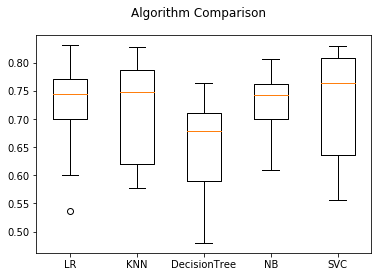

In [497]:
# 箱线图
fig = plt.figure()
fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(models.keys())
plt.show()

# 可以看出LR、SVC、KNN、NB的效果最好，选择这四个模型作为baseline

In [498]:
from sklearn.model_selection import GridSearchCV
# LR算法调参
param_grid = {
             "penalty": ['l1', 'l2'],
             "max_iter": [50, 100, 200, 500, 1000]}
lr_model = LogisticRegression()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=lr_model, 
                   param_grid=param_grid,
                   scoring=scoring,
                   cv=kfold)
grid_result = grid.fit(X=train_set_prepared, y=y)
print("最优： %s 使用 %s" % (grid_result.best_score_,
                       grid_result.best_params_))
cv_results = zip(grid_result.cv_results_["mean_test_score"],
                grid_result.cv_results_["std_test_score"],
                grid_result.cv_results_["params"])
for mean, std, param in cv_results:
    print("%f (%f) with %r" % (mean, std, param))

最优： 0.718377471129965 使用 {'max_iter': 50, 'penalty': 'l2'}
0.716891 (0.083556) with {'max_iter': 50, 'penalty': 'l1'}
0.718377 (0.084174) with {'max_iter': 50, 'penalty': 'l2'}
0.716891 (0.083556) with {'max_iter': 100, 'penalty': 'l1'}
0.718377 (0.084174) with {'max_iter': 100, 'penalty': 'l2'}
0.716891 (0.083556) with {'max_iter': 200, 'penalty': 'l1'}
0.718377 (0.084174) with {'max_iter': 200, 'penalty': 'l2'}
0.716891 (0.083556) with {'max_iter': 500, 'penalty': 'l1'}
0.718377 (0.084174) with {'max_iter': 500, 'penalty': 'l2'}
0.716891 (0.083556) with {'max_iter': 1000, 'penalty': 'l1'}
0.718377 (0.084174) with {'max_iter': 1000, 'penalty': 'l2'}


In [499]:
# KNN算法调参
param_grid = {"n_neighbors": [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
             "weights": ["uniform", "distance"],
             "algorithm": ["auto", "ball_tree", "kd_tree", 'brute'],
             "p": [1, 2, 3]}
knn_model = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=knn_model, param_grid=param_grid,
                   scoring=scoring, cv=kfold)
grid_result = grid.fit(X=train_set_prepared, y=y)

print("最优： %s 使用%s" %(grid_result.best_score_, grid_result.best_params_))
cv_results = zip(grid_result.cv_results_["mean_test_score"],
                grid_result.cv_results_["std_test_score"],
                grid_result.cv_results_["params"])
for mean, std, param in cv_results:
    print("%f (%f) with %r" % (mean, std, param))

最优： 0.7319129270095486 使用{'algorithm': 'auto', 'n_neighbors': 19, 'p': 1, 'weights': 'distance'}
0.681234 (0.083470) with {'algorithm': 'auto', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
0.681234 (0.083470) with {'algorithm': 'auto', 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}
0.678989 (0.077170) with {'algorithm': 'auto', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
0.678989 (0.077170) with {'algorithm': 'auto', 'n_neighbors': 1, 'p': 2, 'weights': 'distance'}
0.677919 (0.077336) with {'algorithm': 'auto', 'n_neighbors': 1, 'p': 3, 'weights': 'uniform'}
0.677919 (0.077336) with {'algorithm': 'auto', 'n_neighbors': 1, 'p': 3, 'weights': 'distance'}
0.724705 (0.108063) with {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.721418 (0.095009) with {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
0.705597 (0.113081) with {'algorithm': 'auto', 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
0.699036 (0.087340) with {'algorithm': 'auto

In [500]:
# SVC调参
param_grid = {"C": [2.0, 2.2, 2.4, 2.6, 2.8, 3.0], 
             "kernel": ["linear", "poly", "rbf", "sigmoid"],
             "degree": [1, 3, 5, 7, 10]}
svc_model = SVC()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=svc_model, param_grid=param_grid,
                   scoring=scoring, cv=kfold)
grid_result = grid.fit(X=train_set_prepared, y=y)
print("最优：%s 使用%s" % (grid_result.best_score_, grid_result.best_params_))
cv_results = zip(grid_result.cv_results_["mean_test_score"],
                grid_result.cv_results_["std_test_score"],
                grid_result.cv_results_["params"])
for mean, std, param in cv_results:
    print("%f (%f) with %r" % (mean, std, param))

最优：0.7419423746535344 使用{'C': 2.6, 'degree': 1, 'kernel': 'rbf'}
0.703208 (0.106431) with {'C': 2.0, 'degree': 1, 'kernel': 'linear'}
0.703208 (0.106431) with {'C': 2.0, 'degree': 1, 'kernel': 'poly'}
0.733642 (0.096637) with {'C': 2.0, 'degree': 1, 'kernel': 'rbf'}
0.627492 (0.077615) with {'C': 2.0, 'degree': 1, 'kernel': 'sigmoid'}
0.703208 (0.106431) with {'C': 2.0, 'degree': 3, 'kernel': 'linear'}
0.693474 (0.106146) with {'C': 2.0, 'degree': 3, 'kernel': 'poly'}
0.733642 (0.096637) with {'C': 2.0, 'degree': 3, 'kernel': 'rbf'}
0.627492 (0.077615) with {'C': 2.0, 'degree': 3, 'kernel': 'sigmoid'}
0.703208 (0.106431) with {'C': 2.0, 'degree': 5, 'kernel': 'linear'}
0.587726 (0.090587) with {'C': 2.0, 'degree': 5, 'kernel': 'poly'}
0.733642 (0.096637) with {'C': 2.0, 'degree': 5, 'kernel': 'rbf'}
0.627492 (0.077615) with {'C': 2.0, 'degree': 5, 'kernel': 'sigmoid'}
0.703208 (0.106431) with {'C': 2.0, 'degree': 7, 'kernel': 'linear'}
0.537842 (0.097011) with {'C': 2.0, 'degree': 7, '

In [501]:
# 集成方法
ensembles = {}
ensembles["AB"] = AdaBoostClassifier()
ensembles["GBM"] = GradientBoostingClassifier()
ensembles["RFR"] = RandomForestClassifier()
ensembles["ETR"] = ExtraTreesClassifier()

results = []
for key in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_result = cross_val_score(ensembles[key], train_set_prepared, y, cv=kfold, 
                               scoring=scoring)
    results.append(cv_result)
    print("%s: %f (%f)" % (key, cv_result.mean(), cv_result.std()))

AB: 0.708022 (0.100507)
GBM: 0.723145 (0.121962)
RFR: 0.702561 (0.122835)
ETR: 0.706142 (0.096074)


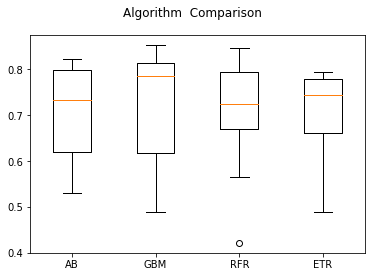

In [502]:
# 箱线图
fig = plt.figure()
fig.suptitle("Algorithm  Comparison")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(ensembles.keys())
plt.show()

In [503]:
# 集成算法调参
param_grid = {"n_estimators": [10, 50, 100, 200, 300, 400, 500, 600, 
                              700, 800, 900]}
model = GradientBoostingClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                   scoring=scoring, cv=kfold)
grid_result = grid.fit(X=train_set_prepared, y=y)
print("最优： %s使用%s" %(grid_result.best_score_, 
                    grid_result.best_params_))

最优： 0.7325374195500973使用{'n_estimators': 200}


In [504]:
X = dev_set.drop(["Survived"], axis=1)
y_val = dev_set["Survived"]
dev_set

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,566,0,3,"Davies, Mr. Alfred J",male,24.0,2,0,A/4 48871,24.1500,NaN,S
1,161,0,3,"Cribb, Mr. John Hatfield",male,44.0,0,1,371362,16.1000,NaN,S
2,554,1,3,"Leeni, Mr. Fahim (""Philip Zenni"")",male,22.0,0,0,2620,7.2250,NaN,C
3,861,0,3,"Hansen, Mr. Claus Peter",male,41.0,2,0,350026,14.1083,NaN,S
4,242,1,3,"Murphy, Miss. Katherine ""Kate""",female,NaN,1,0,367230,15.5000,NaN,Q
5,560,1,3,"de Messemaeker, Mrs. Guillaume Joseph (Emma)",female,36.0,1,0,345572,17.4000,NaN,S
6,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
7,537,0,1,"Butt, Major. Archibald Willingham",male,45.0,0,0,113050,26.5500,B38,S
8,699,0,1,"Thayer, Mr. John Borland",male,49.0,1,1,17421,110.8833,C68,C
9,100,0,2,"Kantor, Mr. Sinai",male,34.0,1,0,244367,26.0000,NaN,S


In [519]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# 模型最终
model = SVC(C=2.6, degree=1, kernel="rbf")
model.fit(X=train_set_prepared, y=y)

# 评估模型
validationX = full_pipeline.transform(dev_set)
predictions = model.predict(validationX)
print(accuracy_score(y_val, predictions))
print(confusion_matrix(y_val, predictions))
print(classification_report(y_val, predictions))

0.7932960893854749
[[98 12]
 [25 44]]
             precision    recall  f1-score   support

          0       0.80      0.89      0.84       110
          1       0.79      0.64      0.70        69

avg / total       0.79      0.79      0.79       179



In [520]:
# joblib保存模型
from sklearn.externals import joblib

joblib.dump(model, "titanic_predictions.pkl")

['titanic_predictions.pkl']

In [522]:
# 加载模型
model = joblib.load("titanic_predictions.pkl")
validationX = full_pipeline.transform(dev_set)
predictions = model.predict(validationX)
print(accuracy_score(y_val, predictions))



0.7932960893854749
